# Who said it?

In [1]:
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import json
import gc

In [2]:
df = pd.read_csv("the-office-lines_scripts.csv")

# list of 5 most common speakers
speakers = df['speaker'].value_counts().head(5).index.tolist()

# filter dataframe to only include the 5 most common speakers
df = df[df['speaker'].isin(speakers)]
df['encoded_speaker'] = df['speaker'].astype('category').cat.codes

# only keep the speaker and line columns
df = df[['speaker', 'line_text', 'encoded_speaker']]

data_text = df['line_text'].to_list()
data_labels = df['encoded_speaker'].to_list()

In [3]:
from sklearn.utils import class_weight
import numpy as np

# create class weight dictionary
class_weight_dict = class_weight.compute_class_weight('balanced', classes=np.unique(data_labels), y=data_labels)
class_weight_dict = dict(enumerate(class_weight_dict))

In [115]:
# list of unique speakers with their encodings
dict(zip(df['speaker'], df['encoded_speaker']))

the_real_speaker_list = ["Andy", "Dwight", "Jim", "Michael", "Pam"]

In [5]:
df.head()

,speaker,line_text,encoded_speaker
0,Michael,All right Jim. Your quarterlies look very good...,3
1,Jim,"Oh, I told you. I couldn't close it. So...",2
2,Michael,So you've come to the master for guidance? Is ...,3
3,Jim,"Actually, you called me in here, but yeah.",2
4,Michael,"All right. Well, let me show you how it's done.",3


In [6]:
# mmax length of a sentence
df['line_text'].str.split(" ").str.len().mean()

12.629958406610278

In [7]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_text, data_labels, test_size=0.2, random_state=0)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [9]:
class TheOfficeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
         input_ids = torch.tensor(self.encodings['input_ids'][idx])
         labels = torch.tensor(self.labels[idx])

         return input_ids, labels

    def __len__(self):
        return len(self.labels)

In [73]:
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)
val_dataset = TheOfficeDataset(val_encodings, val_labels)

In [11]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Set the optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=4e-5)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
train_dataset = TheOfficeDataset(train_encodings, train_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


device = "cuda"
# Train the model
model.train()
model = model.to(device)


for epoch in range(3):
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    #eval 
    model.eval()

    val_loss = 0
    val_accuracy = 0
    for batch in tqdm(val_loader):
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=labels)
            val_loss += outputs.loss.item()
            val_accuracy += (outputs.logits.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)
    print(f"Epoch {epoch} - Validation loss: {val_loss} - Validation accuracy: {val_accuracy}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Epoch 0 - Validation loss: 1.3953203135835273 - Validation accuracy: 0.41311933007676205


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:03<00:00, 134.23it/s]


Epoch 1 - Validation loss: 1.3870132568159275 - Validation accuracy: 0.41284019539427774


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:04<00:00, 90.27it/s]

Epoch 2 - Validation loss: 1.5010077560852682 - Validation accuracy: 0.425261688764829


In [22]:
# save model to disk
save_directory = "/sentence_classifier" # change this to your preferred location
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/sentence_classifier/tokenizer_config.json',
 '/sentence_classifier/special_tokens_map.json',
 '/sentence_classifier/vocab.txt',
 '/sentence_classifier/added_tokens.json')

In [116]:
test_sample_str = "This is a test sentence"
test_sample = tokenizer.encode(test_sample_str, truncation=True, padding=True, return_tensors='pt')
test_sample = test_sample.to(device)
output = model(test_sample)
# visualize
import plotly.express as px
output = torch.softmax(output.logits, dim=1)
output = output.detach().cpu().numpy()
px.bar(x=the_real_speaker_list, y=output[0], title=f"'{test_sample_str}'")


In [23]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = DistilBertForSequenceClassification.from_pretrained(save_directory)

In [118]:
test_text = 'Beesly, you are the worst.'

test_text_pred = tokenizer.encode(test_text, truncation=True, padding=True, return_tensors='pt')
test_text_pred = test_text_pred.to(device)
output = model(test_text_pred)
output = torch.softmax(output.logits, dim=1)[0]

print(
    "Andy: {:.2f}%\tDwight: {:.2f}%\tJim: {:.2f}%\tMichael: {:.2f}%\tPam: {:.2f}%".format(
        100 * output[0],
        100 * output[1],
        100 * output[2],
        100 * output[3],
        100 * output[4]
    )
)

Andy: 1.00%	Dwight: 5.66%	Jim: 48.65%	Michael: 43.44%	Pam: 1.26%


Best examples:
- "And this is how to stab someone in the back."
- "Hi i'm Michael Scott, and I'm the regional manager."
- "That's what she said."
- "Beesly"

In [89]:
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [90]:
# create a confusion matrix evaluating the above class predictions
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Validation dataset size: {}".format(len(val_dataset)))

val_predictions = []

for batch in tqdm(val_loader):
    input_ids, labels = batch
    input_ids = input_ids.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=labels)
        val_predictions.extend(outputs.logits.argmax(1).tolist())


Validation dataset size: 7165


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 7165/7165 [01:50<00:00, 65.10it/s]


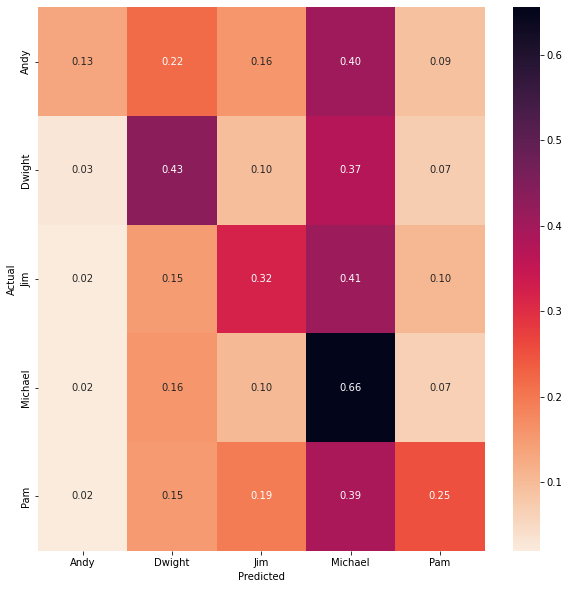

In [119]:
# create a confusion matrix evaluating the above class predictions (normalized)
cm = confusion_matrix(val_labels, val_predictions, normalize='true')

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='rocket_r', annot=True, fmt='.2f', xticklabels=the_real_speaker_list, yticklabels=the_real_speaker_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [130]:
def predict(inputs):
    # Convert input data to tensors
    inputs = loaded_tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
    # Make predictions
    outputs = model(inputs['input_ids'], inputs['attention_mask'])
    # Apply softmax to get class probabilities
    probs = torch.nn.functional.softmax(outputs, dim=1)
    # Get predicted class index
    _, pred = torch.max(probs, dim=1)
    # Convert predicted class index to class label
    labels = [val_dataset.get_label_by_index(i.item()) for i in pred]
    return labels


In [153]:
val_richtig_encoded = tokenizer(val_texts, truncation=True, padding=True, max_length=32, return_tensors='pt')

In [156]:
val_richtig_encoded

{'input_ids': tensor([[  101,  2821,  2026,  ...,     0,     0,     0],
        [  101,  2053,  2009,  ...,     0,     0,     0],
        [  101,  2017,  1005,  ...,  1045,  1005,   102],
        ...,
        [  101, 10166,  1012,  ...,     0,     0,     0],
        [  101,  3398,  1010,  ...,     0,     0,     0],
        [  101,  2288,  2009,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [192]:
from transformers import pipeline

pipe = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0)

In [201]:
import shap

explainer = shap.Explainer(pipe)
shap_values = explainer(val_texts[:10])

In [202]:
# visualize the first prediction's explanation
shap.plots.text(shap_values)

In [209]:
shap_values = explainer(val_texts[:1000])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Partition explainer: 1001it [32:06,  1.93s/it]                                                                                        


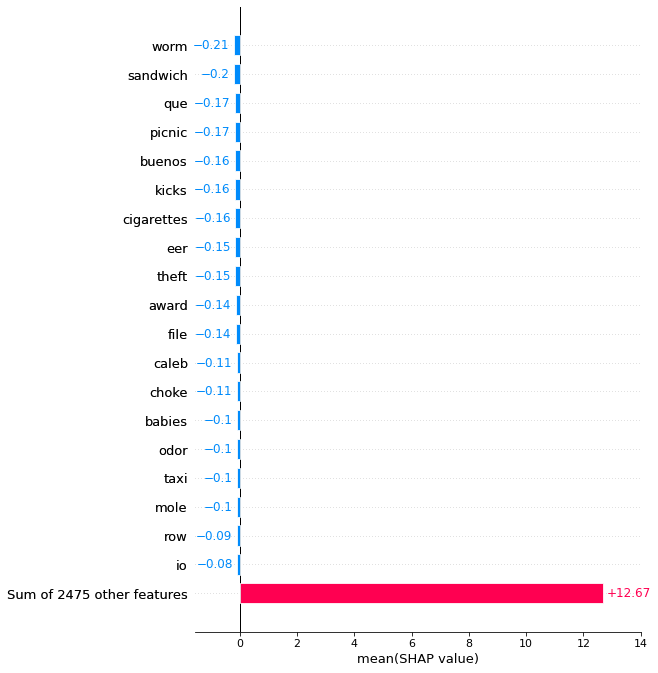

In [215]:
shap.plots.bar(shap_values[:,:,0].mean(0), order=shap.Explanation.argsort, max_display=20)